<a href="https://colab.research.google.com/github/sgulyano/aic402/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIC-402 Lab 5: Face Recognition Using Eigenfaces

CMKL University

By Sarun Gulyanon


### Goal

Explore how dimensionality reduction can improve the performance of a supervised learning pipeline, particularly in cases where the input data have a high number of features compared to the number of available samples.

### Outline

In this lab, we study how Principal Component Analysis (PCA) can be used to reduce the dimensionality of face images to obtain *Eigenfaces*. We then demonstrate that performing face recognition using these *Eigenface* representations yields better results than performing recognition directly on raw pixel values.

----




In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics

## 1. Load and Prepare Dataset

In this lab, we will use the [Olivetti faces dataset](https://scikit-learn.org/0.19/datasets/olivetti_faces.html). This dataset is from AT&T consists of 10 pictures each of 40 individuals. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).

This dataset contains a set of face images taken between April 1992 and April 1994 at AT&T Laboratories Cambridge.

In [2]:
from sklearn.datasets import fetch_olivetti_faces
olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [3]:
images = olivetti['images']
target = olivetti['target']
print(f"There are {images.shape[0]} images in the dataset")
print(f"There are {len(np.unique(target))} unique targets in the dataset")
print(f"Size of each image is {images.shape[1]}x{images.shape[2]}")
print(f"Pixel values were scaled to [{images.min()},{images.max()}] interval")
print("unique target number:",np.unique(target))

There are 400 images in the dataset
There are 40 unique targets in the dataset
Size of each image is 64x64
Pixel values were scaled to [0.0,1.0] interval
unique target number: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


Split the dataset into training and test data.

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images,
                                                    target,
                                                    stratify=target,
                                                    test_size=0.2)
print(f'Train Image: {x_train.shape}')
print(f'Train Label: {y_train.shape}')
print(f'Test Image: {x_test.shape}')
print(f'Test Label: {y_test.shape}')
print(f"There are {len(np.unique(y_train))} unique targets in the training data")
print(f"There are {len(np.unique(y_test))} unique targets in the testing data")

Train Image: (320, 64, 64)
Train Label: (320,)
Test Image: (80, 64, 64)
Test Label: (80,)
There are 40 unique targets in the training data
There are 40 unique targets in the testing data


Sanity Check: Display a sample from each class

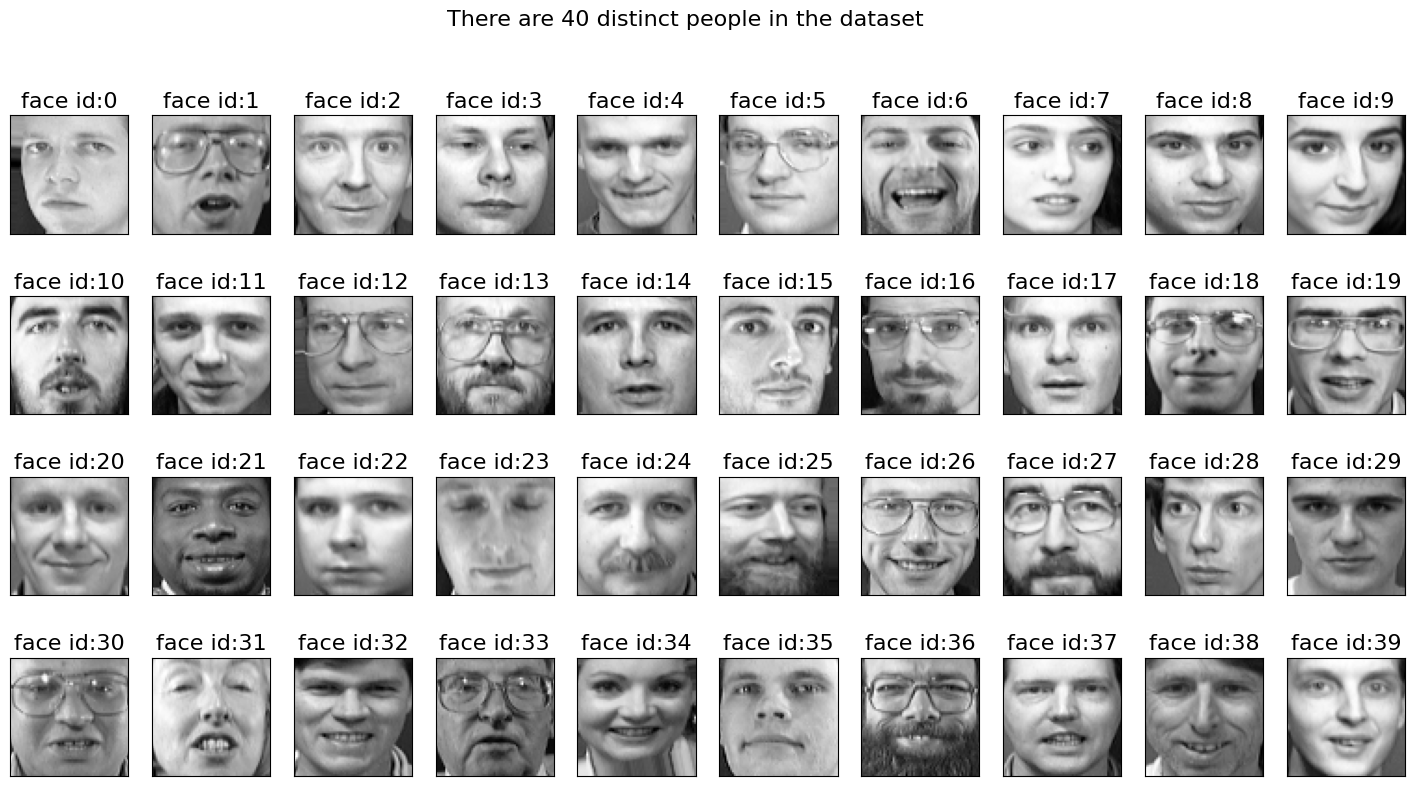

In [5]:
plt.figure(figsize=(18, 9))
for unique_id in np.unique(y_train):
    img_idx = np.where(y_train==unique_id)[0][0]
    plt.subplot(4, 10, unique_id + 1)
    plt.imshow(x_train[img_idx], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'face id:{unique_id}', fontsize = 16)
plt.suptitle("There are 40 distinct people in the dataset", fontsize = 16)
plt.show()

Sanity Check: Display all face images of a single person

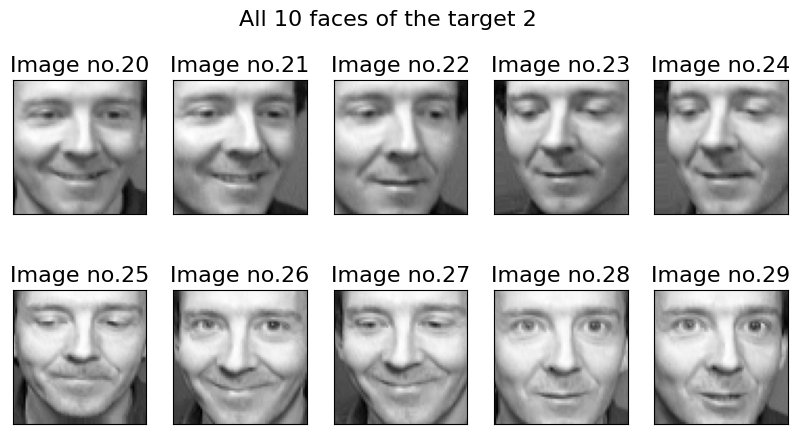

In [6]:
img_idx = np.where(target==2)[0]
plt.figure(figsize=(10, 5))
for i, img in enumerate(images[img_idx]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Image no.{img_idx[i]}', fontsize = 16)
plt.suptitle("All 10 faces of the target 2", fontsize = 16)
plt.show()

## 2. Classification Using Logistic Regression

[Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) computes the probability that an input belongs to each person (class) by applying a non-linear function (sigmoid) to the output of a linear model, converting the linear scores into probabilities.

In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty=None)

model.fit(x_train.reshape(x_train.shape[0], -1), y_train)
y_pred = model.predict(x_test.reshape(x_test.shape[0], -1))

Evaluate the model using accuracy, i.e., the proportion of samples the model predicts correctly.

In [8]:
print("Accuracy score:{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy score:0.81


Sanity Check: Inspect the mode's predictions.

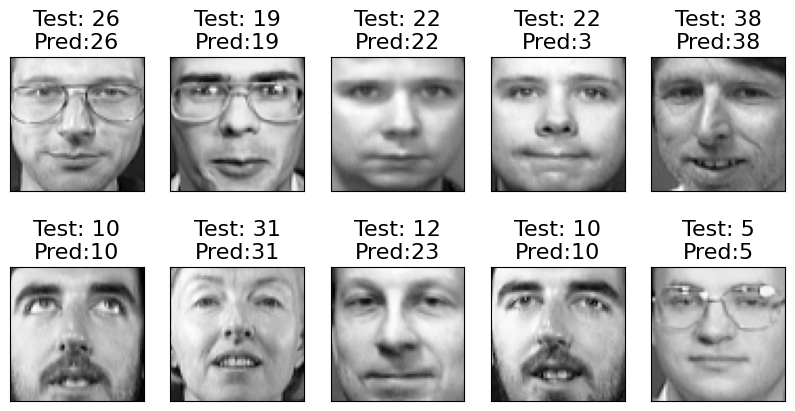

In [9]:
plt.figure(figsize=(10,5))
for i in range(10):
    image, label, pred = x_test[i+20], y_test[i+20], y_pred[i+20]
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(image, (64,64)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Test: {label}\nPred:{pred}', fontsize = 16)
    plt.grid(False)

Plot [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to examine the model's performance for each individual (class).

In [10]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

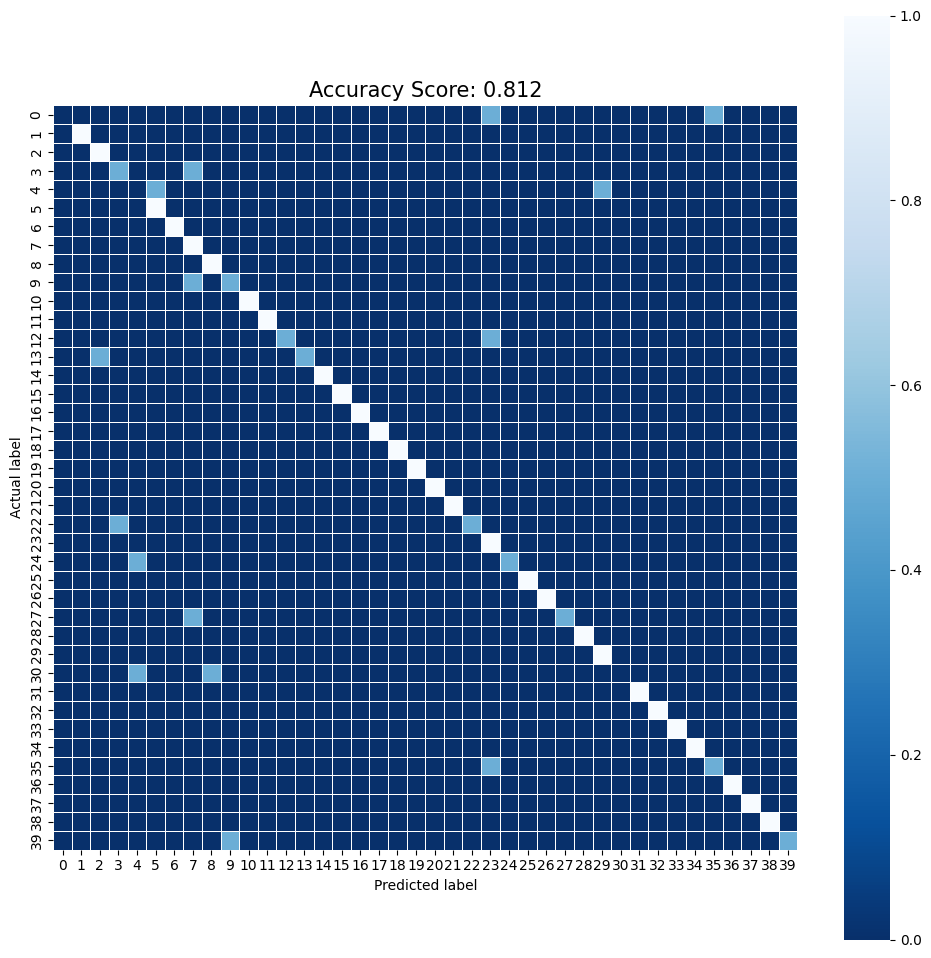

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(cm_normalized,
            linewidths=.5,
            square = True,
            cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

## 3. Eigenface

Eigenfaces are a compact representation of face images obtained by applying [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to a dataset of aligned face images. PCA identifies the principal directions of variation in the data, allowing each face image to be expressed as a linear combination of a small number of basis images, called *eigenfaces*.

These low-dimensional representations can then be used as input features for supervised learning models, such as Logistic Regression, resulting in more efficient and often more accurate face recognition compared to using raw pixel values directly.

In [12]:
x_train.reshape(x_train.shape[0], -1).shape

(320, 4096)

In [13]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
x_train_pca2 = pca2.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_test_pca2 = pca2.transform(x_test.reshape(x_test.shape[0], -1))

In [14]:
print(f'เดิม Training data ขนาด {x_train.reshape(x_train.shape[0], -1).shape} หลังจากทำ PCA กลายเป็น {x_train_pca2.shape}')

เดิม Training data ขนาด (320, 4096) หลังจากทำ PCA กลายเป็น (320, 2)


Sanity Check: Plot the data after PCA using samples from only 10 people.

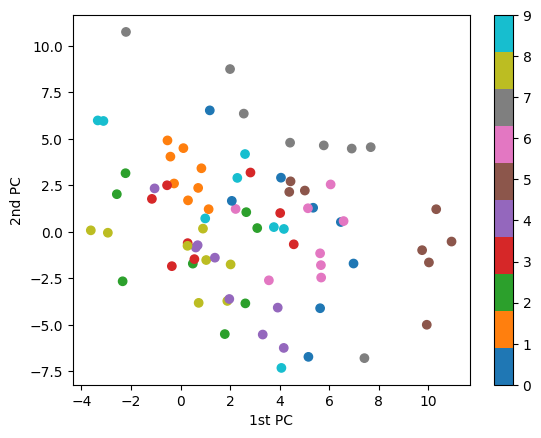

In [15]:
plt.scatter(x_train_pca2[y_train < 10,0], x_train_pca2[y_train < 10,1], c=y_train[y_train < 10], cmap='tab10')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.colorbar()
plt.show()

Compute the explained variance of the principal components.

In [16]:
pca2.explained_variance_ratio_

array([0.23813288, 0.13132934], dtype=float32)

In [17]:
pca2.explained_variance_

array([18.76008, 10.34611], dtype=float32)

In practice, we often choose the number of components so that they explain 95% of the dataset's variance.

In [18]:
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_test_pca = pca.transform(x_test.reshape(x_test.shape[0], -1))
print(f'Train PCA data: {x_train_pca.shape}')
print(f'Test PCA data: {x_test_pca.shape}')

Train PCA data: (320, 111)
Test PCA data: (80, 111)


Sanity Check: Since PCA is applied to images, each principal component corresponds to an image.

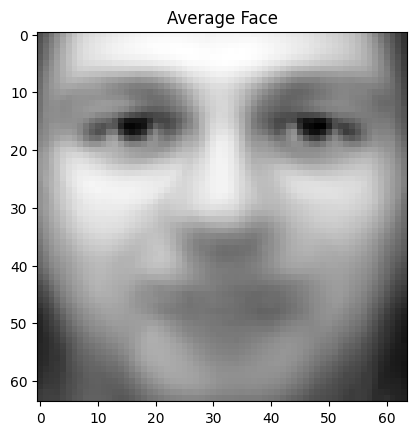

In [19]:
plt.imshow(pca.mean_.reshape((64,64)), cmap="gray")
plt.title('Average Face')
plt.grid(False)

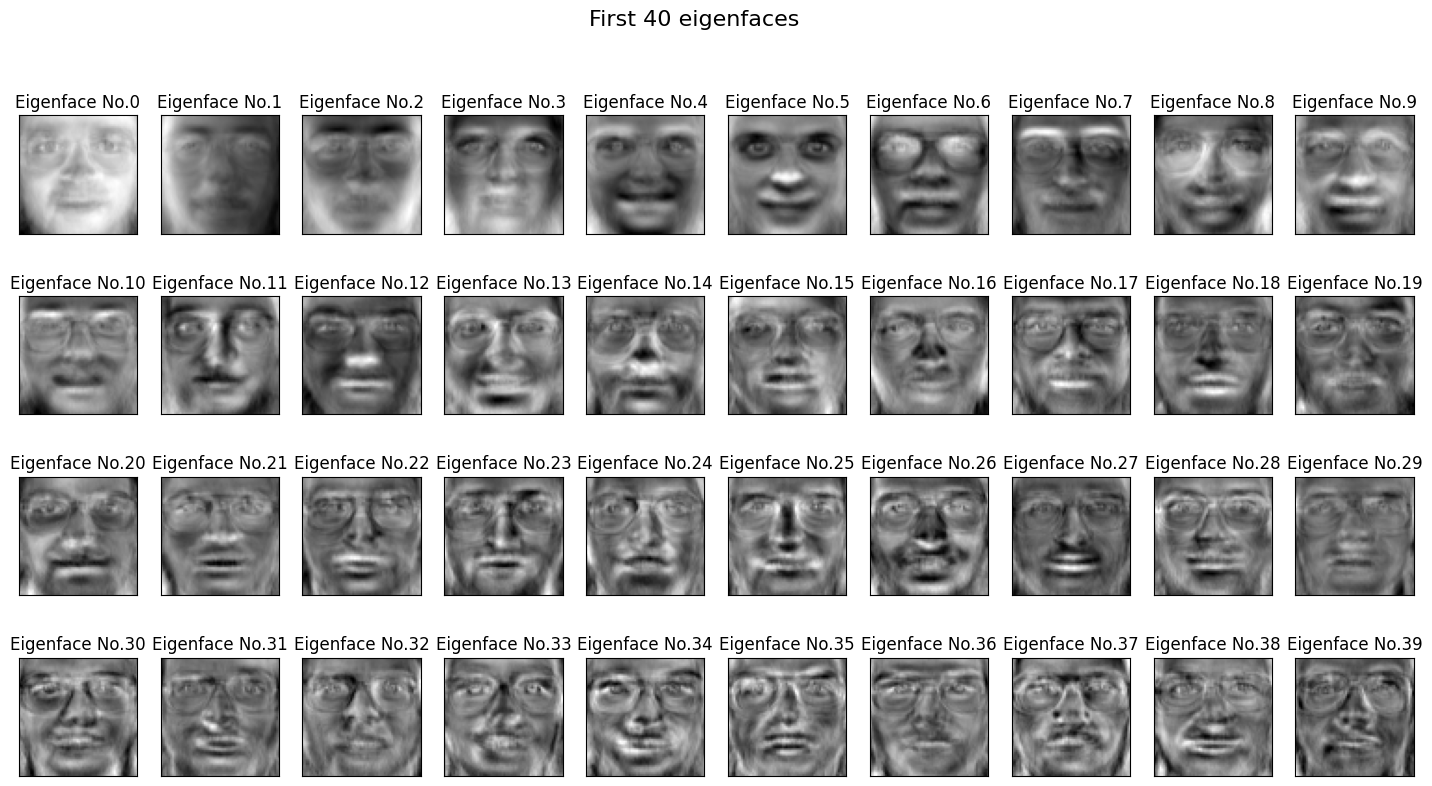

In [20]:
eigen_faces = pca.components_.reshape((-1,64,64))

plt.figure(figsize=(18, 9))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(eigen_faces[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Eigenface No.{i}', fontsize = 12)
    plt.grid(False)
plt.suptitle("First 40 eigenfaces", fontsize = 16)
plt.show()

### Exercise:
Observe the facial structures and regions emphasized in the eigenfaces, and compare early and later components. Briefly explain how these observations relate to improved face recognition performance.

## 4. Classification Using Eigenfaces

We continue to use Logistic Regression, but replace the raw pixel inputs with Eigenface features.

In [21]:
model = LogisticRegression(penalty=None)

model.fit(x_train_pca, y_train)
y_pred_pca = model.predict(x_test_pca)

Evaluate the model using accuracy. You should observe a significant improvement, increasing from approximately 80% to around 90%.

In [22]:
print("Accuracy score:{:0.2f}".format(metrics.accuracy_score(y_test, y_pred_pca)))

Accuracy score:0.96


Sanity Check: Inspect the model's predictions. You should observe that some images are classified more correctly than before.

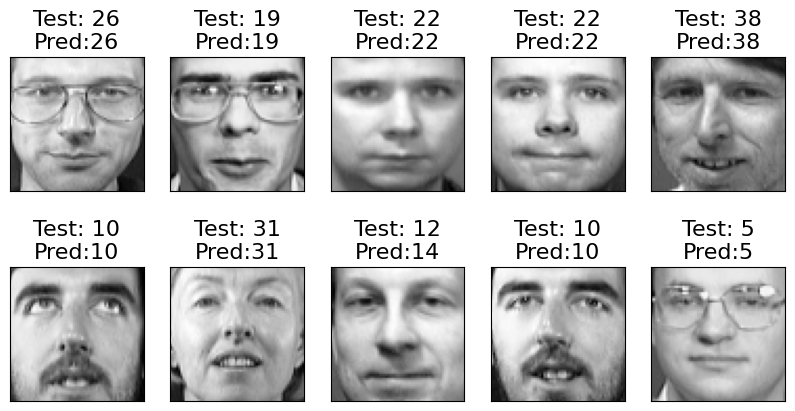

In [23]:
plt.figure(figsize=(10,5))
for i in range(10):
    image, label, pred = x_test[i+20], y_test[i+20], y_pred_pca[i+20]
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(image, (64,64)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Test: {label}\nPred:{pred}', fontsize = 16)
    plt.grid(False)

Plot a confusion matrix to examine the model's performance for each individual. You should observe higher accuracy across classes.

In [24]:
cm = metrics.confusion_matrix(y_test, y_pred_pca)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

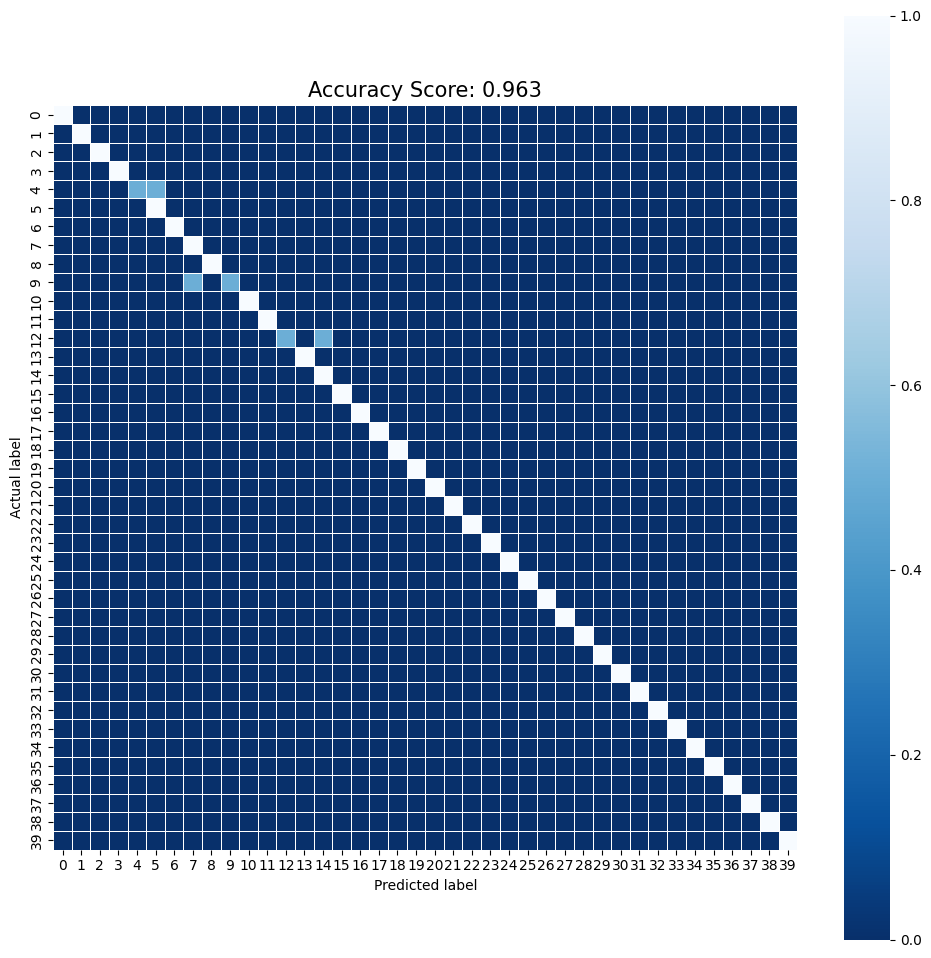

In [25]:
plt.figure(figsize=(12,12))
sns.heatmap(cm_normalized,
            linewidths=.5,
            square = True,
            cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred_pca))
plt.title(all_sample_title, size = 15);

### Cross-Validation

Another commonly used technique for model evaluation is [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html). The dataset is divided into several groups, called folds. In each iteration, one fold is used as the test set while the remaining folds are used for training. This process is repeated until every fold has been used as the test set once.

Cross-validation is especially useful when the dataset is small, as it allows all available data to be used for both training and evaluation.

In [26]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(model, x_train_pca, y_train, cv=5)
print(cv)

[0.953125 0.96875  0.953125 0.953125 0.953125]


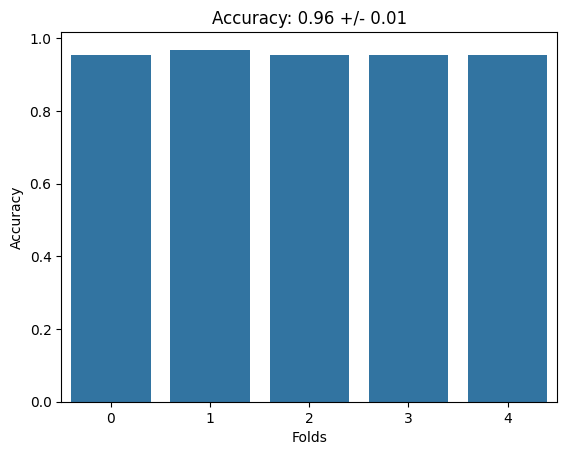

In [27]:
ax = sns.barplot(x=list(range(5)), y=cv)
ax.set(xlabel='Folds', ylabel='Accuracy')
ax.set_title('Accuracy: {:0.2f} +/- {:0.2f}'.format(cv.mean(), cv.std()*2))
plt.show()

----